In [40]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import (Compose,Normalize)
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [41]:
def load_image(img_path, transform):
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

In [42]:
def pgd_attack(model, images, labels, eps=0.3, alpha=0.01, iters=40):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()

    ori_images = images.clone().detach()

    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach()

    return images

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eps=2/255
alpha = 0.01
iterations = 40

In [64]:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [65]:
model = models.resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [66]:

# original prediction of the image is centripede(79)
img_path = '../images/Example_image_2.jpg'  # Replace with your image path
image = load_image(img_path, transform)
image = image.to(device)

In [67]:
originl_pred=model(image)
original_pred=originl_pred.argmax()
original_pred

tensor(79)

In [68]:
label = torch.tensor([original_pred]).to(device)  # Replace with the correct label for your image

In [69]:
adv_image = pgd_attack(model, image, label, eps, alpha, iterations)

In [70]:
new_image=model(adv_image)
new_image=new_image.argmax()
new_image

tensor(794)

In [71]:
original_image = image.squeeze(0).cpu().detach().numpy().transpose((1, 2, 0))  # Convert to NumPy array and reshape
adversarial_image = adv_image.squeeze(0).cpu().detach().numpy().transpose((1, 2, 0))

differnce=np.abs(original_image-adversarial_image).mean(axis=-1)
difference=differnce/differnce.max()

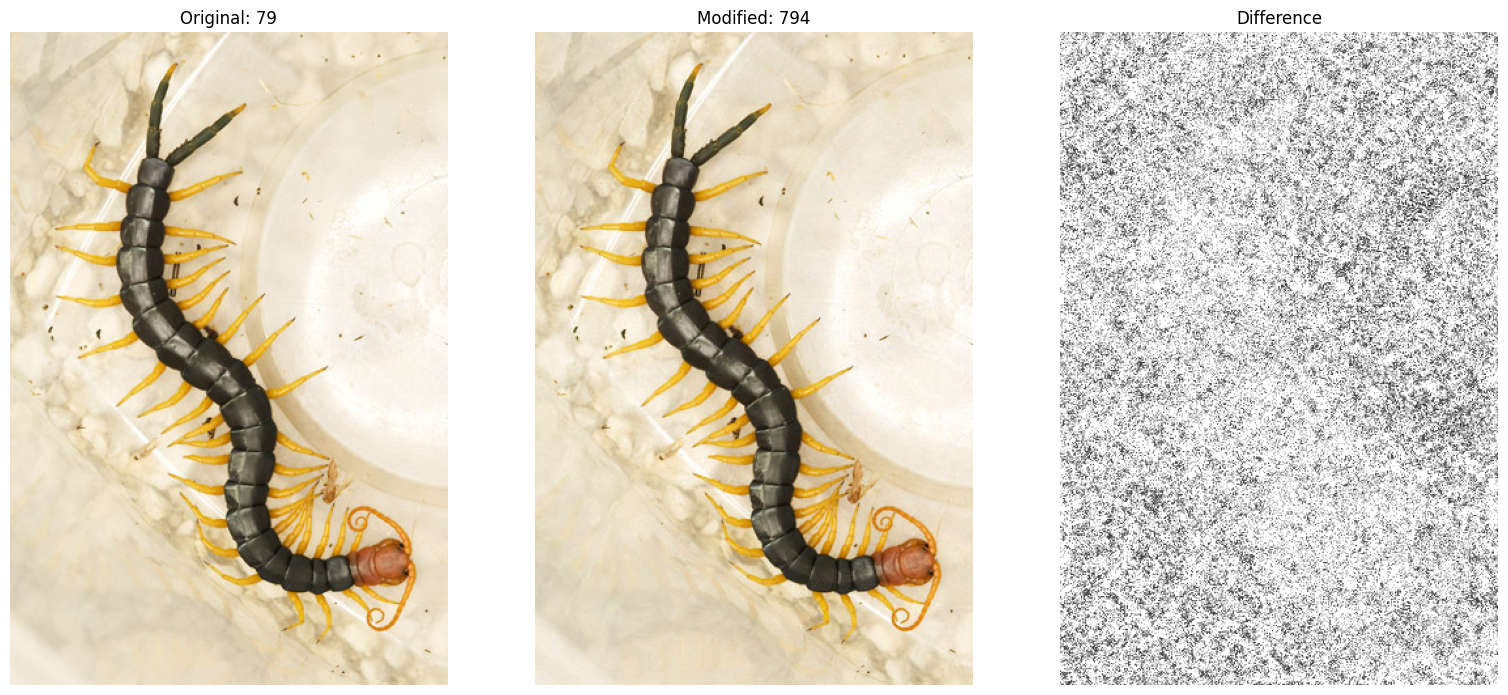

In [72]:

_, (ax_orig, ax_new, ax_diff) = plt.subplots(1, 3, figsize=(19.20,10.80))

ax_orig.imshow(original_image)
ax_new.imshow(adversarial_image)
ax_diff.imshow(difference, cmap="gray")

ax_orig.axis("off")
ax_new.axis("off")
ax_diff.axis("off")

ax_orig.set_title(f"Original: {original_pred}")
ax_new.set_title(f"Modified: {new_image}")
ax_diff.set_title("Difference")

plt.savefig("AttackedImages/PGD_attack.png")